# NYC 311 Service Requests: XGBoost

This notebook builds an end-to-end classification model using NYC 311 data to predict whether a complaint will be resolved within 7 days. It includes feature engineering, model training, evaluation, drift detection, and SHAP explainability. Data Source is found at: https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9/about_data


In [10]:
# Imports
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import shap
import matplotlib.pyplot as plt

## Load and Prepare Data

In [11]:
# FULL DATASET DOWNLOADED AS CSV FROM THE WEBPAGE: 311_Service_Requests_from_2010_to_Present.csv
# This dataset contains differences in schema names with regards to csv's downloaded from API. 
# For example, Created Date instead of created_date.
# We are using the API version

# # Load your dataset - THIS IS FOR THE DATASET REQUESTED VIA API
df = pd.read_csv('311_Service_Requests_2023.csv', parse_dates=['created_date', 'closed_date'], low_memory=False)

df = df.dropna(subset=['created_date', 'closed_date'])
df['resolution_time'] = (df['closed_date'] - df['created_date']).dt.days
df['resolved_within_7days'] = (df['resolution_time'] <= 7).astype(int)


In [12]:
# Feature selection & preparation
features = ['complaint_type', 'borough', 'agency', 'incident_zip', 'created_date'] # 'Zip Code', 'Agency', 'Created Date']
df = df[features + ['resolved_within_7days']].dropna()

df['created_hour'] = df['created_date'].dt.hour
df['created_weekday'] = df['created_date'].dt.weekday

# Drop original date to prevent leakage
df = df.drop(columns=['created_date'])

df.head()

,complaint_type,borough,agency,incident_zip,resolved_within_7days,created_hour,created_weekday
0,Noise - Street/Sidewalk,QUEENS,NYPD,11375.0,1,23,6
1,Noise - Helicopter,MANHATTAN,EDC,10023.0,0,23,6
2,Blocked Driveway,QUEENS,NYPD,11355.0,1,23,6
3,Noise - Street/Sidewalk,QUEENS,NYPD,11374.0,1,23,6
4,Noise - Street/Sidewalk,BROOKLYN,NYPD,11232.0,1,23,6


In [13]:
# Encode categoricals
for col in ['complaint_type', 'borough', 'agency', 'incident_zip']: # 'Zip Code']:
    df[col] = df[col].astype('category').cat.codes

X = df.drop(columns=['resolved_within_7days'])
y = df['resolved_within_7days']

## Train XGBoost Model

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'seed': 42
}

model = xgb.train(params, dtrain, num_boost_round=100, evals=[(dtest, 'test')], early_stopping_rounds=10)
y_pred = model.predict(dtest)
auc = roc_auc_score(y_test, y_pred)
print(f'Test ROC AUC: {auc:.4f}')

[0]	test-auc:0.97321
[1]	test-auc:0.97498
[2]	test-auc:0.97582
[3]	test-auc:0.97767
[4]	test-auc:0.97795
[5]	test-auc:0.97845
[6]	test-auc:0.97900


[7]	test-auc:0.97937
[8]	test-auc:0.97916
[9]	test-auc:0.97916
[10]	test-auc:0.97998
[11]	test-auc:0.98005
[12]	test-auc:0.98030
[13]	test-auc:0.98050
[14]	test-auc:0.98054
[15]	test-auc:0.98044
[16]	test-auc:0.98043
[17]	test-auc:0.98066
[18]	test-auc:0.98070
[19]	test-auc:0.98081
[20]	test-auc:0.98089
[21]	test-auc:0.98095
[22]	test-auc:0.98098
[23]	test-auc:0.98137
[24]	test-auc:0.98142
[25]	test-auc:0.98124
[26]	test-auc:0.98125
[27]	test-auc:0.98122
[28]	test-auc:0.98093
[29]	test-auc:0.98120
[30]	test-auc:0.98115
[31]	test-auc:0.98133
[32]	test-auc:0.98125
[33]	test-auc:0.98117
Test ROC AUC: 0.9812


## Population Stability Index (PSI) for Drift Detection

In [15]:
def psi(expected, actual, buckets=10):
    breakpoints = np.percentile(expected, np.linspace(0, 100, buckets + 1))
    expected_counts = np.histogram(expected, bins=breakpoints)[0] / len(expected)
    actual_counts = np.histogram(actual, bins=breakpoints)[0] / len(actual)

    psi_value = np.sum((expected_counts - actual_counts) * np.log((expected_counts + 1e-4) / (actual_counts + 1e-4)))
    return psi_value

# Example: Check drift for Complaint Type
psi_value = psi(X_train['complaint_type'], X_test['complaint_type'])
print(f'PSI for Complaint Type: {psi_value:.4f}')

PSI for Complaint Type: 0.0056


## SHAP Explainability

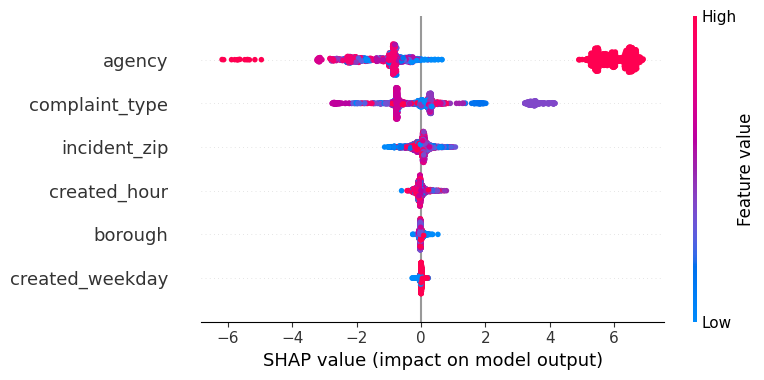

In [16]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)